In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
%pdb off

from pyCascade import probePost, physics, utils
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
import os
from IPython.core.debugger import set_trace
import pandas as pd

category =  "config2"

############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)

Automatic pdb calling has been turned OFF


'/scratch/users/nbachand/Cascade/city_block_cfd'

'/home/users/nbachand/Cascade/city_block_cfd'

In [2]:
hm = 6
window_dim = hm/2/4

velocity_scaling = 1
ventilation_scaling = velocity_scaling/(window_dim**2)

norm_vel = probePost.quick_dict_apply(lambda data_df: data_df*velocity_scaling)
norm_vent = probePost.quick_dict_apply(
    lambda data_df: data_df*velocity_scaling)
abs_values = probePost.quick_dict_apply(lambda df: df.abs())
norm_data = lambda data_df : data_df*ventilation_scaling
flip_data = probePost.quick_dict_apply(lambda data_df: -data_df)


In [3]:
run = 15
qoisOutputed = ["mass_flux", "comp(u,0)"]
qois= ["mass_flux"]

probes_dir = f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut'

# probes = probePost.Probes(probes_dir, probe_type = "FLUX_PROBES", flux_quants = qoisOutputed)
# probes.to_parquet(overwrite = True)

probes = probePost.Probes(probes_dir, probe_type = "FLUX_PROBES", flux_quants = qoisOutputed, file_type = "parquet")



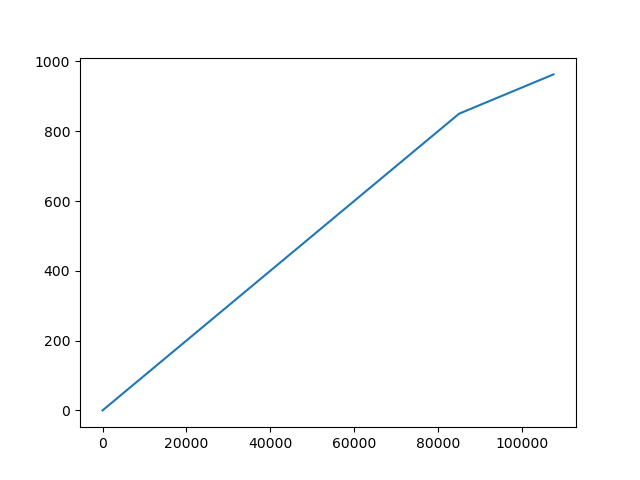

In [4]:
plt.figure()
plt.plot(probes.probe_steps, probes.probe_times)
plt.show()

In [5]:
start = 50000
stop = 80000
by = 1

(0.0, 2.45)

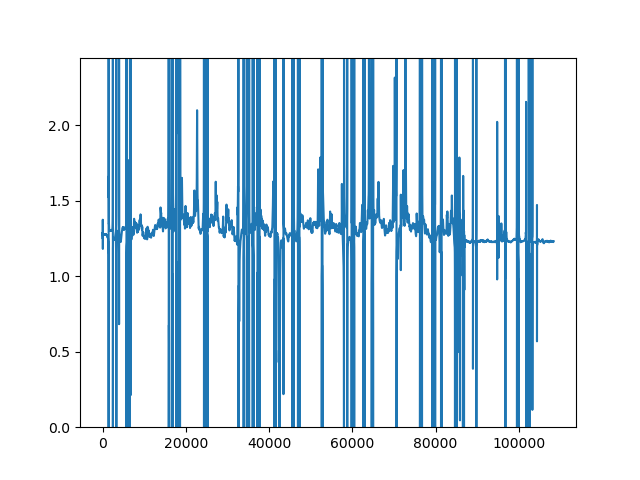

In [6]:
plt.figure()
foo_mass = probes.data[("xwindow_0-0_h_3-0_Bx", qoisOutputed[0])].compute()
foo_u = probes.data[("xwindow_0-0_h_3-0_Bx", qoisOutputed[1])].compute()
foo_area = probes.areas["xwindow_0-0_h_3-0_Bx"]
plt.plot(foo_mass.values/foo_u.values)
plt.ylim(0,1.225*2)


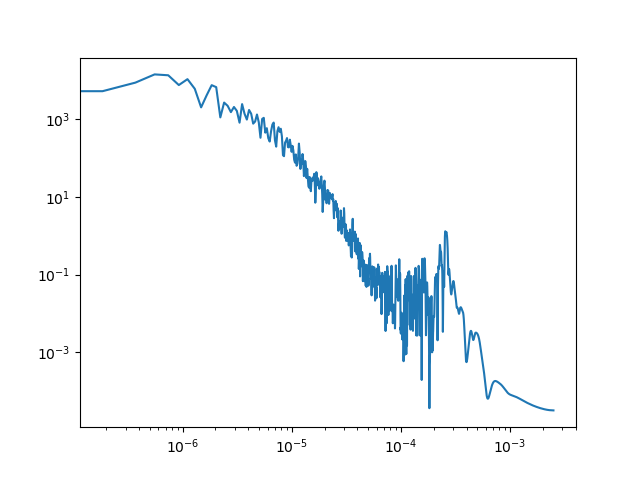

In [7]:
plt.figure()
N = len(foo_mass)
f, E = sp.signal.welch(foo_mass.values, fs = probes.dt, axis = 0, nperseg = N//4, scaling = 'density', detrend = 'constant') 
plt.loglog(f, E)

## X Flow


In [49]:
norm_norm = probePost.quick_apply(
    lambda df: probePost.mul_names(df, [name for name in probes.probe_names if "Bxz" in name or "Bz" in name], -1)
)

# (fig, ax) = probes.time_plots(
#     names = [name for name in  probes.probe_names if "xwindow_" in name], 
#     steps = probes.probe_steps[start:stop:by],
#     quants = qois,
#     plot_params = {
#         'stack span' : 'y',
#         'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
#         'xlabel' : 'time $[s]$',
#         'horizontal spacing' : probes.probe_times,
#         },
#     processing = [norm_vent, norm_norm],
#     parrallel=True
#     )

## mean statistics
x_mean = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, probePost.time_average, norm_norm],
    parrallel=False
    )

## rms statistics
x_rms = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, probePost.time_rms],
    parrallel=False
    )

## Net flow
x_net = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, abs_values, probePost.time_average],
    parrallel=False
    )

processing data took 4 seconds
processing data took 4 seconds
processing data took 4 seconds


In [50]:
flowStats = pd.concat([x_mean, x_rms, x_net], axis = "columns")
flowStats.columns = ["x_mean", "x_rms", "x_net"]
display(flowStats)


,x_mean,x_rms,x_net
xwindow_0-0_h_3-0,0.032416,0.209407,0.172849
xwindow_0-0_h_3-0_Bx,0.170074,0.149075,0.194725
xwindow_0-0_h_3-0_Bxz,-0.057641,0.151122,0.132763
xwindow_0-0_h_3-0_Bz,-0.660153,0.250358,0.666188
xwindow_0-0_h_3-1,0.091894,0.169747,0.153620
xwindow_0-0_h_3-1_Bx,0.035392,0.132483,0.106005
xwindow_0-0_h_3-1_Bxz,-0.070153,0.144522,0.130585
xwindow_0-0_h_3-1_Bz,-0.459349,0.401773,0.524024
xwindow_0-0_h_3-2,-0.001243,0.151448,0.120985
xwindow_0-0_h_3-2_Bx,0.151898,0.128512,0.169389


In [51]:
locs = probes.get_avg_locations()

In [52]:
locs

,x,y,z
xwindow_0-1_h_3-1,46.027321,1.500066,37.999542
skylight_2-0_sl_Bxz,-47.997557,2.895130,-58.001247
zwindow_2-1_h_3-3_Bxz,-56.000000,1.500000,-87.960078
zwindow_2-1_h_3-1,56.000000,1.500000,39.959370
skylight_0-1_sl_Bxz,-39.998571,2.902005,-61.999969
...,...,...,...
xdoor_1-1_h_3-2_Bz,62.000000,1.500000,-58.008348
zwindow_1-0_h_3-3_Bxz,-51.998952,1.494973,-80.111585
zwindow_0-0_sl_Bxz,-40.000000,1.500000,-56.045868
xwindow_0-0_h_3-1_Bx,-34.001286,1.497641,46.106147


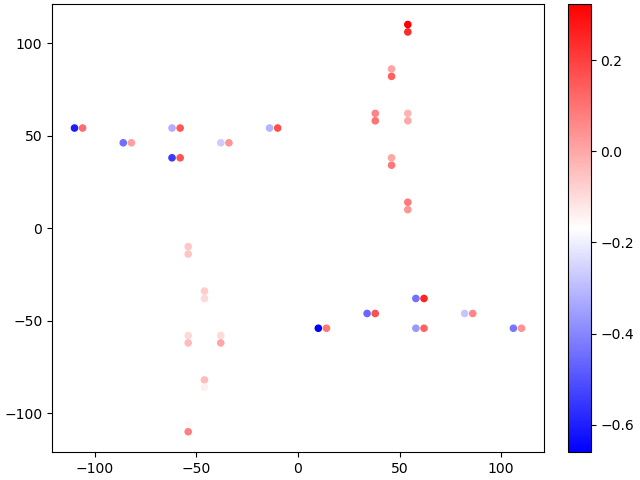

In [54]:
fig, ax = plt.subplots(1, 1, constrained_layout =True)
im = ax.scatter(locs.loc[flowStats.index, 'x'], locs.loc[flowStats.index, 'z'], s = 20, c = flowStats["x_mean"], cmap = 'bwr')
fig.colorbar(im)

In [ ]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/xwindows')

x_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xmean.csv')
x_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xrms.csv')
x_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xnet.csv')

## Z Flow


In [ ]:
norm_norm = probePost.quick_apply(
    lambda df: probePost.mul_names(df, ['zwindow_0-1', 'zwindow_1-1', 'zwindow_2-1'], -1)
)

(fig, ax) = probes.time_plots(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,2)'],
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probes.probe_times,
        },
    processing = [norm_vent, probePost.linear_quadrature],
    parrallel=True
    )

## mean statistics
z_mean = ventilation_scaling * probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,2)'],
    processing = [norm_vent, probePost.linear_quadrature, probePost.time_average, norm_norm],
    parrallel=False
    )

## rms statistics
z_rms = probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,2)'],
    processing = [norm_vent, probePost.linear_quadrature, probePost.time_rms],
    parrallel=False
    )

## Net flow
z_net = probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,0)'],
    processing = [norm_vent, probePost.linear_quadrature, abs_values, probePost.time_average],
    parrallel=False
    )

display(z_mean)
display(z_rms)
display(z_net)

In [ ]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/zwindows')

z_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/zmean.csv')
z_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/zrms.csv')
z_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/znet.csv')

## Y Flow


In [ ]:
(fig, ax) = probes.time_plots(
    names = [name for name in  probes.probe_names if "skylight_" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,2)'],
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probes.probe_times,
        },
    processing = [norm_vent, probePost.linear_quadrature],
    parrallel=True
    )

## mean statistics
y_mean = ventilation_scaling * probes.statistics(
    names = [name for name in  probes.probe_names if "skylight_" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,2)'],
    processing = [norm_vent, probePost.linear_quadrature, probePost.time_average],
    parrallel=False
    )

## rms statistics
y_rms = probes.statistics(
    names = [name for name in  probes.probe_names if "skylight_" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,2)'],
    processing = [norm_vent, probePost.linear_quadrature, probePost.time_rms],
    parrallel=False
    )

## Net flow
y_net = probes.statistics(
    names = [name for name in  probes.probe_names if "skylight_" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,0)'],
    processing = [norm_vent, probePost.linear_quadrature, abs_values, probePost.time_average],
    parrallel=False
    )

display(y_mean)
display(y_rms)
display(y_net)

In [ ]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/ywindows')

y_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/ymean.csv')
y_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/yrms.csv')
y_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/ynet.csv')